In [1]:
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ks_2samp
from pandas.api.types import is_numeric_dtype

def nulls(df, only_nulls = True):
    '''
    Returns what % of rows for each feature is nulls \n
    if only_nulls is set to True, only the features with any nulls in 
    them are returned. Default : True \n
    '''
    ans = (100*round(df.isnull().sum()/len(df),4).sort_values(
        ascending=False))
    if only_nulls:
        return ans[ans>0]
    else:
        return ans
    
def get_vif(df):
    '''
    Returns the Variance Inflation Factor for all the features 
    in the dataframe df
    '''
    df1 = df
    # Removing non-numeric features from vif calculations
    for column in list(df.columns):
        if not is_numeric_dtype(df[column]):
            df1.drop(column, axis = 1, inplace = True)
    vif=pd.DataFrame()
    vif['Features'] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) 
                                for i in range(df1.shape[1])]
    vif['VIF'] = round(vif.VIF,2)
    vif = vif.sort_values(by = 'VIF', ascending = False)
    return vif

def get_kss(df1, df2):
    ks_stat, p_value = ks_2samp(
        df1['logerror'].values, df2['logerror'].values
    )
    print('KS Statistic: %0.3f, P-Value: %0.3f' % (ks_stat, p_value))  

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Load the dataset

In [4]:
z_train = pd.read_csv(r'/content/drive/MyDrive/CMU Classwork/17634-Applied-Machine-Learning/train_2016.csv', low_memory=False)
z_prop = pd.read_csv(r'/content/drive/MyDrive/CMU Classwork/17634-Applied-Machine-Learning/properties_2016.csv', low_memory=False)

# Here make a minor adjustment to float32, where needed
for c, dtype in zip(z_prop.columns, z_prop.dtypes):
	if dtype == np.float64:
		z_prop[c] = z_prop[c].astype(np.float32)

'''
The dataset df is the complete combined dataset. The response field
is 'logerror', and the remaining fields are possible predictors
'''
        
df = z_train.merge(z_prop, how='left', on='parcelid')
df_orig = df.copy()
df.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARS,60371068.0,12447.0,3101.0,31817.0,96370.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,468.0,NaN,NaN,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,261.0,NaN,60590524.0,32380.0,1286.0,NaN,96962.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PSR6,60374640.0,47019.0,3101.0,275411.0,96293.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,266.0,LAR3,60372964.0,12447.0,3101.0,54300.0,96222.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,598.0,NaN,NaN,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,60590424.0,17686.0,1286.0,NaN,96961.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13


Changing transaction date to datetime

In [5]:
df['transactiondate'] = pd.to_datetime(df.transactiondate)

## 2. Missing value treatment

In [6]:
# Checking what % of each feature is nulls
nulls(df, True)

buildingclasstypeid             99.98
finishedsquarefeet13            99.96
storytypeid                     99.95
basementsqft                    99.95
yardbuildingsqft26              99.89
fireplaceflag                   99.75
architecturalstyletypeid        99.71
typeconstructiontypeid          99.67
finishedsquarefeet6             99.53
decktypeid                      99.27
poolsizesum                     98.93
pooltypeid10                    98.71
pooltypeid2                     98.67
taxdelinquencyyear              98.02
taxdelinquencyflag              98.02
hashottuborspa                  97.38
yardbuildingsqft17              97.07
finishedsquarefeet15            96.05
finishedfloor1squarefeet        92.41
finishedsquarefeet50            92.41
fireplacecnt                    89.36
threequarterbathnbr             86.70
pooltypeid7                     81.50
poolcnt                         80.17
numberofstories                 77.21
airconditioningtypeid           68.12
garagecarcnt

Features that are > 80% null

In [7]:
for feature in list(nulls(df)[nulls(df) > 80].index):
    print(df[feature].value_counts())
    print(str(nulls(df)[feature]) + '% nulls', end = '\n' + '-'*20 + '\n')

4.0    16
Name: buildingclasstypeid, dtype: int64
99.98% nulls
--------------------
1440.0    17
1344.0     3
1248.0     3
1392.0     2
1536.0     2
1566.0     1
1464.0     1
1152.0     1
1584.0     1
1416.0     1
1056.0     1
Name: finishedsquarefeet13, dtype: int64
99.96000000000001% nulls
--------------------
7.0    43
Name: storytypeid, dtype: int64
99.95% nulls
--------------------
1528.0    3
1312.0    2
700.0     2
515.0     1
162.0     1
616.0     1
1551.0    1
485.0     1
238.0     1
493.0     1
760.0     1
814.0     1
196.0     1
1350.0    1
585.0     1
234.0     1
510.0     1
579.0     1
100.0     1
608.0     1
802.0     1
312.0     1
913.0     1
690.0     1
168.0     1
671.0     1
1555.0    1
771.0     1
831.0     1
1048.0    1
564.0     1
330.0     1
198.0     1
676.0     1
184.0     1
540.0     1
260.0     1
557.0     1
1210.0    1
Name: basementsqft, dtype: int64
99.95% nulls
--------------------
120.0    6
60.0     3
180.0    3
125.0    3
144.0    3
        ..
159.0    

If we try imputing any of the above columns, we will end up with heavily skewed features that may not be beneficial for our model. Let's drop them.

In [8]:
# Dropping features that have more than 80% nulls
df.drop(
    list(nulls(df)[nulls(df) > 80].index), 
    axis = 1,
    inplace = True
)
nulls(df)

numberofstories                 77.21
airconditioningtypeid           68.12
garagecarcnt                    66.84
garagetotalsqft                 66.84
regionidneighborhood            60.11
heatingorsystemtypeid           37.88
buildingqualitytypeid           36.46
propertyzoningdesc              35.41
unitcnt                         35.36
lotsizesquarefeet               11.24
finishedsquarefeet12             5.18
regionidcity                     2.00
calculatedbathnbr                1.31
fullbathcnt                      1.31
yearbuilt                        0.84
calculatedfinishedsquarefeet     0.73
censustractandblock              0.67
structuretaxvaluedollarcnt       0.42
regionidzip                      0.04
taxamount                        0.01
dtype: float64

For features with less than 5% of rows null, we can consider dropping the rows. Let's explore this.

In [9]:
df2 = df.copy()
for column in list(nulls(df)[nulls(df) < 5].index):
    df2 = df2[df2[column].notna()]

In [10]:
get_kss(df, df2)

KS Statistic: 0.002, P-Value: 1.000


The KS Statistic is low, and the p value is very high. Hence, we can conclude that the distribution of logerror is retained after dropping these rows. Thus, we can proceed the MCAR values

In [11]:
df = df2.copy()
nulls(df)

numberofstories          76.97
airconditioningtypeid    68.21
garagecarcnt             66.48
garagetotalsqft          66.48
regionidneighborhood     59.19
heatingorsystemtypeid    37.20
buildingqualitytypeid    35.85
propertyzoningdesc       35.18
unitcnt                  35.13
lotsizesquarefeet        10.95
finishedsquarefeet12      4.08
dtype: float64

In [12]:
# We still have 96% of the data retained
df.shape[0]/df_orig.shape[0] * 100

96.39988922736084

In [13]:
for feature in list(nulls(df).index):
    print(df[feature].value_counts())
    print(str(nulls(df)[feature]) + '% nulls', end = '\n' + '-'*20 + '\n')

1.0    11807
2.0     7737
3.0      494
4.0        2
Name: numberofstories, dtype: int64
76.97% nulls
--------------------
1.0     25598
13.0     1798
5.0       207
11.0       63
9.0         1
3.0         1
Name: airconditioningtypeid, dtype: int64
68.21000000000001% nulls
--------------------
2.0     21510
1.0      6571
3.0       648
4.0       254
0.0        92
5.0        53
6.0        14
7.0        11
8.0         7
9.0         5
11.0        2
10.0        2
24.0        1
13.0        1
14.0        1
Name: garagecarcnt, dtype: int64
66.47999999999999% nulls
--------------------
0.0       8857
400.0      945
441.0      793
462.0      720
360.0      720
          ... 
1142.0       1
296.0        1
983.0        1
359.0        1
1027.0       1
Name: garagetotalsqft, Length: 862, dtype: int64
66.47999999999999% nulls
--------------------
118208.0    766
48570.0     752
27080.0     748
37739.0     696
48200.0     652
           ... 
761098.0      1
764136.0      1
763791.0      1
762949.0     

In [14]:
nulls(df)

numberofstories          76.97
airconditioningtypeid    68.21
garagecarcnt             66.48
garagetotalsqft          66.48
regionidneighborhood     59.19
heatingorsystemtypeid    37.20
buildingqualitytypeid    35.85
propertyzoningdesc       35.18
unitcnt                  35.13
lotsizesquarefeet        10.95
finishedsquarefeet12      4.08
dtype: float64

In [15]:
# Let us explore number of stories
df.numberofstories.value_counts()

1.0    11807
2.0     7737
3.0      494
4.0        2
Name: numberofstories, dtype: int64

The nulls here cannot mean 0s. (it does not make sense to have a house with 0 levels)

In [16]:
# Imputing with mode
df['numberofstories'] = df['numberofstories'].fillna(
    df.numberofstories.mode()[0]
)
nulls(df)

airconditioningtypeid    68.21
garagetotalsqft          66.48
garagecarcnt             66.48
regionidneighborhood     59.19
heatingorsystemtypeid    37.20
buildingqualitytypeid    35.85
propertyzoningdesc       35.18
unitcnt                  35.13
lotsizesquarefeet        10.95
finishedsquarefeet12      4.08
dtype: float64

In [17]:
# Exploring airconditioningtypeid
df.airconditioningtypeid.value_counts()

1.0     25598
13.0     1798
5.0       207
11.0       63
9.0         1
3.0         1
Name: airconditioningtypeid, dtype: int64

In [18]:
# Impute with mode
df['airconditioningtypeid'] = df['airconditioningtypeid'].fillna(
    df.airconditioningtypeid.mode()[0]
)
nulls(df)

garagecarcnt             66.48
garagetotalsqft          66.48
regionidneighborhood     59.19
heatingorsystemtypeid    37.20
buildingqualitytypeid    35.85
propertyzoningdesc       35.18
unitcnt                  35.13
lotsizesquarefeet        10.95
finishedsquarefeet12      4.08
dtype: float64

In [19]:
df.garagecarcnt.value_counts()

2.0     21510
1.0      6571
3.0       648
4.0       254
0.0        92
5.0        53
6.0        14
7.0        11
8.0         7
9.0         5
11.0        2
10.0        2
24.0        1
13.0        1
14.0        1
Name: garagecarcnt, dtype: int64

In [20]:
# Impute with mode
df['garagecarcnt'] = df['garagecarcnt'].fillna(
    df.garagecarcnt.mode()[0]
)
nulls(df)

garagetotalsqft          66.48
regionidneighborhood     59.19
heatingorsystemtypeid    37.20
buildingqualitytypeid    35.85
propertyzoningdesc       35.18
unitcnt                  35.13
lotsizesquarefeet        10.95
finishedsquarefeet12      4.08
dtype: float64

In [21]:
df.garagetotalsqft.describe()

count    29172.000000
mean       347.290283
std        266.117279
min          0.000000
25%          0.000000
50%        434.000000
75%        484.000000
max       7339.000000
Name: garagetotalsqft, dtype: float64

In [22]:
garage_counts = list(df.garagecarcnt.value_counts().index)
garage_counts

[2.0,
 1.0,
 3.0,
 4.0,
 0.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 11.0,
 10.0,
 24.0,
 13.0,
 14.0]

Finding the mean area of garage for each kind of garage

In [23]:
mean_garage_areas = { count : df[df.garagecarcnt == count]
                                ['garagetotalsqft'].mean()
                                for count in garage_counts}
mean_garage_areas

{0.0: 1.3695652484893799,
 1.0: 124.26860809326172,
 2.0: 390.60693359375,
 3.0: 759.504638671875,
 4.0: 976.720458984375,
 5.0: 1303.4150390625,
 6.0: 1632.357177734375,
 7.0: 1982.3636474609375,
 8.0: 2313.0,
 9.0: 2738.0,
 10.0: 3077.0,
 11.0: 3355.0,
 13.0: 4048.0,
 14.0: 4384.0,
 24.0: 7339.0}

Imputing null values for garagetotalsqft using mean of area of each kind of garage

In [24]:
df.loc[df.garagetotalsqft.isna(), 'garagetotalsqft'] = \
    df[df.garagetotalsqft.isna()].garagecarcnt.apply(
        lambda x : mean_garage_areas[x]
    )
nulls(df)

regionidneighborhood     59.19
heatingorsystemtypeid    37.20
buildingqualitytypeid    35.85
propertyzoningdesc       35.18
unitcnt                  35.13
lotsizesquarefeet        10.95
finishedsquarefeet12      4.08
dtype: float64

Exploring regionidneighborhood

In [25]:
df.regionidneighborhood.value_counts()

118208.0    766
48570.0     752
27080.0     748
37739.0     696
48200.0     652
           ... 
761098.0      1
764136.0      1
763791.0      1
762949.0      1
762937.0      1
Name: regionidneighborhood, Length: 491, dtype: int64

In [26]:
# Imputing regionID with mode
df.regionidneighborhood.fillna(
    df.regionidneighborhood.value_counts().index[0],
    inplace = True
)
nulls(df)

heatingorsystemtypeid    37.20
buildingqualitytypeid    35.85
propertyzoningdesc       35.18
unitcnt                  35.13
lotsizesquarefeet        10.95
finishedsquarefeet12      4.08
dtype: float64

Exploring heatingorsystemtypeid    

In [27]:
df.heatingorsystemtypeid.value_counts()

2.0     37137
7.0     15313
24.0     1065
6.0       957
13.0       75
20.0       58
18.0       25
1.0        13
14.0        2
10.0        2
11.0        1
12.0        1
Name: heatingorsystemtypeid, dtype: int64

In [28]:
# Imputing with mode
df.heatingorsystemtypeid.fillna(
    df.heatingorsystemtypeid.value_counts().index[0],
    inplace = True
)
nulls(df)

buildingqualitytypeid    35.85
propertyzoningdesc       35.18
unitcnt                  35.13
lotsizesquarefeet        10.95
finishedsquarefeet12      4.08
dtype: float64

Exploring buildingqualitytypeid    

In [29]:
df.buildingqualitytypeid.value_counts()

7.0     28885
4.0     22908
1.0      2513
10.0     1397
12.0      116
8.0         4
6.0         1
11.0        1
Name: buildingqualitytypeid, dtype: int64

Checking if buildingqualitytypeid is MCAR

In [30]:
get_kss(
    df.loc[df.buildingqualitytypeid.notna(),:],
    df
)

KS Statistic: 0.028, P-Value: 0.000


The p-value is very low, so it is not MCAR.

Examining propertyzoningdesc

In [31]:
df.propertyzoningdesc.describe()

count     56408
unique     1944
top        LAR1
freq       7632
Name: propertyzoningdesc, dtype: object

This column may not be of much value, and some of it would be covered by propertylandusetypeid

Hence, dropping it.

In [32]:
df.drop('propertyzoningdesc', axis = 1, inplace = True)
nulls(df)

buildingqualitytypeid    35.85
unitcnt                  35.13
lotsizesquarefeet        10.95
finishedsquarefeet12      4.08
dtype: float64

Exploring unitcnt

In [33]:
df.unitcnt.value_counts()

1.0      53052
2.0       2115
4.0        725
3.0        559
6.0          1
143.0        1
11.0         1
5.0          1
70.0         1
Name: unitcnt, dtype: int64

In [34]:
# Imputing mode
df.unitcnt.fillna(
    df.unitcnt.value_counts().index[0],
    inplace = True
)
nulls(df)

buildingqualitytypeid    35.85
lotsizesquarefeet        10.95
finishedsquarefeet12      4.08
dtype: float64

In [35]:
get_kss(
    df.loc[df.lotsizesquarefeet.notna(),:],
    df
)

KS Statistic: 0.007, P-Value: 0.050


The p-value is at borderline 0.05, let's go ahead with dropping these rows. 

In [36]:
df = df.loc[df.lotsizesquarefeet.notna(),:]
nulls(df)

buildingqualitytypeid    29.56
finishedsquarefeet12      4.55
dtype: float64

We will employ KNN Imputer to fill in the remaining missing values.

First, we scale the features

In [37]:
df_scaled = df.copy()
for column in list(df_scaled.columns):
    if not is_numeric_dtype(df_scaled[column]):
        df_scaled.drop(column, axis = 1, inplace = True)

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# df_scaled = scaler.fit_transform(df_scaled)
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_scaled), 
    columns = df_scaled.columns
)
df_scaled.head()

,parcelid,logerror,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,0.002002,0.495890,0.0,0.052632,0.1875,0.272727,0.052632,0.073970,0.084054,0.000000,0.052632,0.083333,0.053223,0.043478,0.637698,0.511251,0.001056,0.942623,0.000076,0.022785,1.0,0.032837,0.001278,0.000000,0.0,0.569231,0.000000,0.012330,0.012705,0.0,0.009675,0.020774,0.000074
1,0.009106,0.492507,0.0,0.105263,0.1250,0.272727,0.105263,0.097410,0.110689,0.000000,0.105263,0.083333,0.053223,0.043478,0.539723,0.678326,0.001615,0.942623,0.004909,0.110740,1.0,0.354535,0.001024,0.000000,0.0,0.423077,0.000000,0.006222,0.004044,0.0,0.002349,0.035526,0.004903
2,0.012688,0.495269,0.0,0.052632,0.1250,0.272727,0.052632,0.036809,0.041827,0.000000,0.052632,0.083333,0.053223,0.043478,0.282048,0.606931,0.010141,0.963115,0.002641,0.022785,1.0,0.062529,0.000790,0.000000,0.0,0.784615,0.000000,0.017231,0.008549,0.0,0.002979,0.009319,0.002639
3,0.024439,0.492400,0.0,0.078947,0.2500,NaN,0.078947,0.100312,0.113987,0.297297,0.052632,0.083333,0.081482,0.043478,0.099104,0.931359,0.000837,0.942623,0.296872,0.036114,0.0,0.146928,0.003224,0.444444,0.0,0.738462,0.333333,0.017036,0.015386,0.0,0.010800,0.016900,0.296873
4,0.005242,0.463980,0.0,0.157895,0.2500,0.000000,0.157895,0.134790,0.153166,0.000000,0.157895,0.083333,0.053223,0.043478,0.359442,0.556959,0.000365,0.942623,0.007036,0.066709,1.0,0.146928,0.000418,0.000000,0.0,0.746154,0.000000,0.088515,0.087961,0.0,0.063957,0.084121,0.007031


Running KNN Imputer

In [39]:
nulls(df_scaled)

buildingqualitytypeid    29.56
finishedsquarefeet12      4.55
dtype: float64

The scaler will exclude non numeric columns. These will be added back again

In [40]:
excluded = [i for i in df.columns if i not in df_scaled.columns]
excluded

['transactiondate', 'propertycountylandusecode']

In [41]:
df_excluded = df[excluded].reset_index(drop=True)
df_excluded

,transactiondate,propertycountylandusecode
0,2016-01-01,0100
1,2016-01-01,0100
2,2016-01-02,010C
3,2016-01-02,122
4,2016-01-02,0100
...,...,...
77491,2016-12-30,0100
77492,2016-12-30,010C
77493,2016-12-30,0100
77494,2016-12-30,0200


In [42]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_scaled = pd.DataFrame(
    imputer.fit_transform(df_scaled),
    columns = df_scaled.columns
)
nulls(df_scaled)

Series([], dtype: float64)

Running an inverse transform on the scaled dataset to get back the original dataset.

In [43]:
df_imputed = pd.DataFrame(
    scaler.inverse_transform(df_scaled),
    columns = df_scaled.columns
)

In [44]:
# Need to reset index so the indices in the scaled df align with the original
df.reset_index(inplace=True, drop=True)

In [45]:
df.loc[:, 'buildingqualitytypeid'] = df_imputed.loc[:, 'buildingqualitytypeid']
df.loc[:, 'finishedsquarefeet12'] = df_imputed.loc[:, 'finishedsquarefeet12']

In [46]:
df

,parcelid,logerror,transactiondate,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,2.0,3.0,4.0,2.0,1684.0,1684.0,6037.0,2.0,2.0,390.606934,2.0,34280992.0,-118488536.0,7528.0,0100,261.0,60371068.0,12447.0,3101.0,31817.0,96370.0,0.0,1.0,1959.0,1.0,122754.0,360170.0,2015.0,237416.0,6735.879883,6.037107e+13
1,12098116,-0.0040,2016-01-01,1.0,3.0,2.0,4.0,3.0,2217.0,2217.0,6037.0,3.0,2.0,390.606934,2.0,34136312.0,-118175032.0,11423.0,0100,261.0,60374640.0,47019.0,3101.0,275411.0,96293.0,0.0,1.0,1940.0,1.0,61994.0,119906.0,2015.0,57912.0,11484.480469,6.037464e+13
2,12643413,0.0218,2016-01-02,1.0,2.0,2.0,4.0,2.0,839.0,839.0,6037.0,2.0,2.0,390.606934,2.0,33755800.0,-118309000.0,70859.0,010C,266.0,60372964.0,12447.0,3101.0,54300.0,96222.0,0.0,1.0,1987.0,1.0,171518.0,244880.0,2015.0,73362.0,3048.739990,6.037296e+13
3,14432541,-0.0050,2016-01-02,1.0,2.5,4.0,5.2,2.5,2283.0,2283.0,6059.0,2.0,2.0,598.000000,2.0,33485644.0,-117700232.0,6000.0,122,261.0,60590424.0,17686.0,1286.0,118208.0,96961.0,8.0,1.0,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.959961,6.059042e+13
4,11509835,-0.2705,2016-01-02,1.0,4.0,4.0,1.0,4.0,3067.0,3067.0,6037.0,4.0,2.0,390.606934,2.0,33870088.0,-118402768.0,2708.0,0100,261.0,60376212.0,29712.0,3101.0,118208.0,96109.0,0.0,1.0,1982.0,1.0,880650.0,2447951.0,2015.0,1567301.0,27126.570312,6.037621e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77491,12920746,0.0344,2016-12-30,1.0,2.0,3.0,4.0,2.0,1448.0,1448.0,6037.0,2.0,2.0,390.606934,2.0,34098872.0,-117875152.0,7594.0,0100,261.0,60374036.0,24245.0,3101.0,118208.0,96473.0,0.0,1.0,1959.0,1.0,141700.0,405000.0,2015.0,263300.0,5311.029785,6.037404e+13
77492,10774160,-0.0356,2016-12-30,1.0,1.0,1.0,4.0,1.0,653.0,653.0,6037.0,1.0,2.0,390.606934,2.0,34203000.0,-118562000.0,93676.0,010C,266.0,60371316.0,12447.0,3101.0,40548.0,96364.0,0.0,1.0,1979.0,1.0,43800.0,191000.0,2015.0,147200.0,2495.239990,6.037132e+13
77493,12046695,0.0070,2016-12-30,1.0,3.0,3.0,4.0,3.0,2856.0,2856.0,6037.0,3.0,2.0,390.606934,2.0,34198744.0,-118224848.0,9343.0,0100,261.0,60373008.0,45457.0,3101.0,274580.0,96327.0,0.0,1.0,1965.0,1.0,117893.0,161111.0,2015.0,43218.0,1886.540039,6.037301e+13
77494,12995401,-0.2679,2016-12-30,1.0,2.0,4.0,7.0,2.0,2617.0,1838.0,6037.0,2.0,2.0,390.606934,2.0,34075656.0,-118025536.0,6865.0,0200,246.0,60374328.0,51861.0,3101.0,118208.0,96478.0,0.0,2.0,1924.0,1.0,22008.0,38096.0,2015.0,16088.0,1925.699951,6.037433e+13


In [47]:
df.shape

(77496, 35)

In [48]:
nulls(df)

Series([], dtype: float64)

We have now gotten rid of all the nulls in the dataset. Now, since the KNN imputer has returned non integer values for some of the rows, we have to round them off back to ints.

In [49]:
# We can observe decimal values here
df.buildingqualitytypeid.value_counts()

7.0     31846
4.0     27212
5.2      3492
5.8      2684
4.6      2440
6.4      2359
1.0      2346
10.0     1318
5.2      1017
3.4       922
7.6       469
2.8       393
1.6       266
2.2       257
12.0      114
7.0       109
5.8        49
7.6        47
8.2        29
8.8        18
10.4       14
9.0        10
11.2       10
8.6         9
8.0         6
5.6         6
10.8        6
5.0         6
7.8         5
9.6         4
3.8         3
6.4         3
4.4         3
11.6        3
9.4         3
5.0         2
7.4         2
7.2         2
6.2         2
7.8         2
6.8         1
9.0         1
6.6         1
9.6         1
6.0         1
5.4         1
11.0        1
6.8         1
Name: buildingqualitytypeid, dtype: int64

In [50]:
df['buildingqualitytypeid'] = df.buildingqualitytypeid.apply(lambda x: round(x))

In [51]:
df.buildingqualitytypeid.value_counts()

7     31962
4     27218
5      6958
6      5104
1      2346
10     1337
3      1315
8       558
2       523
12      117
9        41
11       17
Name: buildingqualitytypeid, dtype: int64

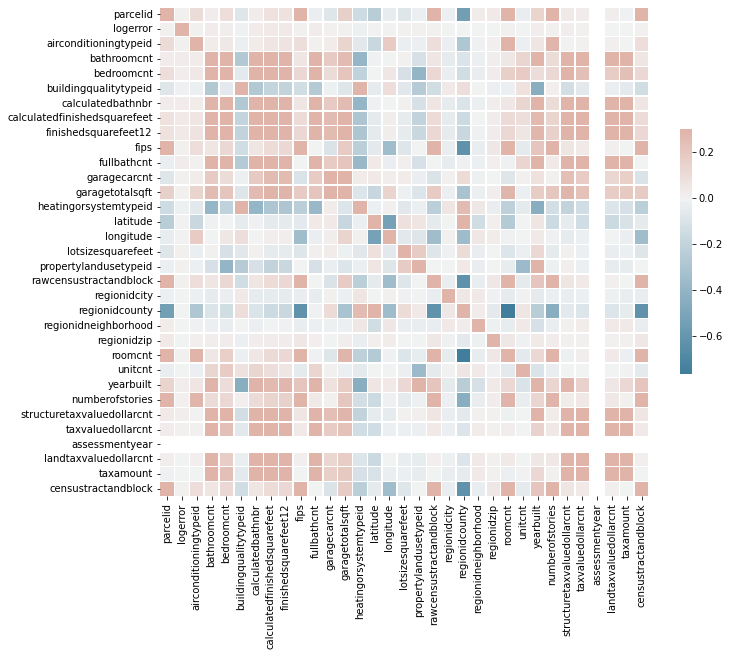

In [52]:
# Correlation matrix visual 
# Ref https://seaborn.pydata.org/examples/many_pairwise_correlations.html

corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 3. EDA and Cleaning

Let's look at what features we have now

In [53]:
df.columns

Index(['parcelid', 'logerror', 'transactiondate', 'airconditioningtypeid',
       'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fips', 'fullbathcnt', 'garagecarcnt',
       'garagetotalsqft', 'heatingorsystemtypeid', 'latitude', 'longitude',
       'lotsizesquarefeet', 'propertycountylandusecode',
       'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'unitcnt', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock'],
      dtype='object')

Let's look at what our categorical features are spread out like. These are nominal categorical features

In [54]:
cat_vars = [
    'airconditioningtypeid',
    'buildingqualitytypeid',
    'fips',
    'heatingorsystemtypeid',
    'propertylandusetypeid',
    'rawcensustractandblock',
    'regionidcity',
    'regionidcounty',
    'regionidcounty',
    'regionidzip',
    'censustractandblock',
    'propertycountylandusecode'
]

In [55]:
df.regionidzip.value_counts()

97319.0    890
97329.0    729
97318.0    712
97328.0    690
96193.0    590
          ... 
96973.0      2
96467.0      1
96034.0      1
97111.0      1
96226.0      1
Name: regionidzip, Length: 385, dtype: int64

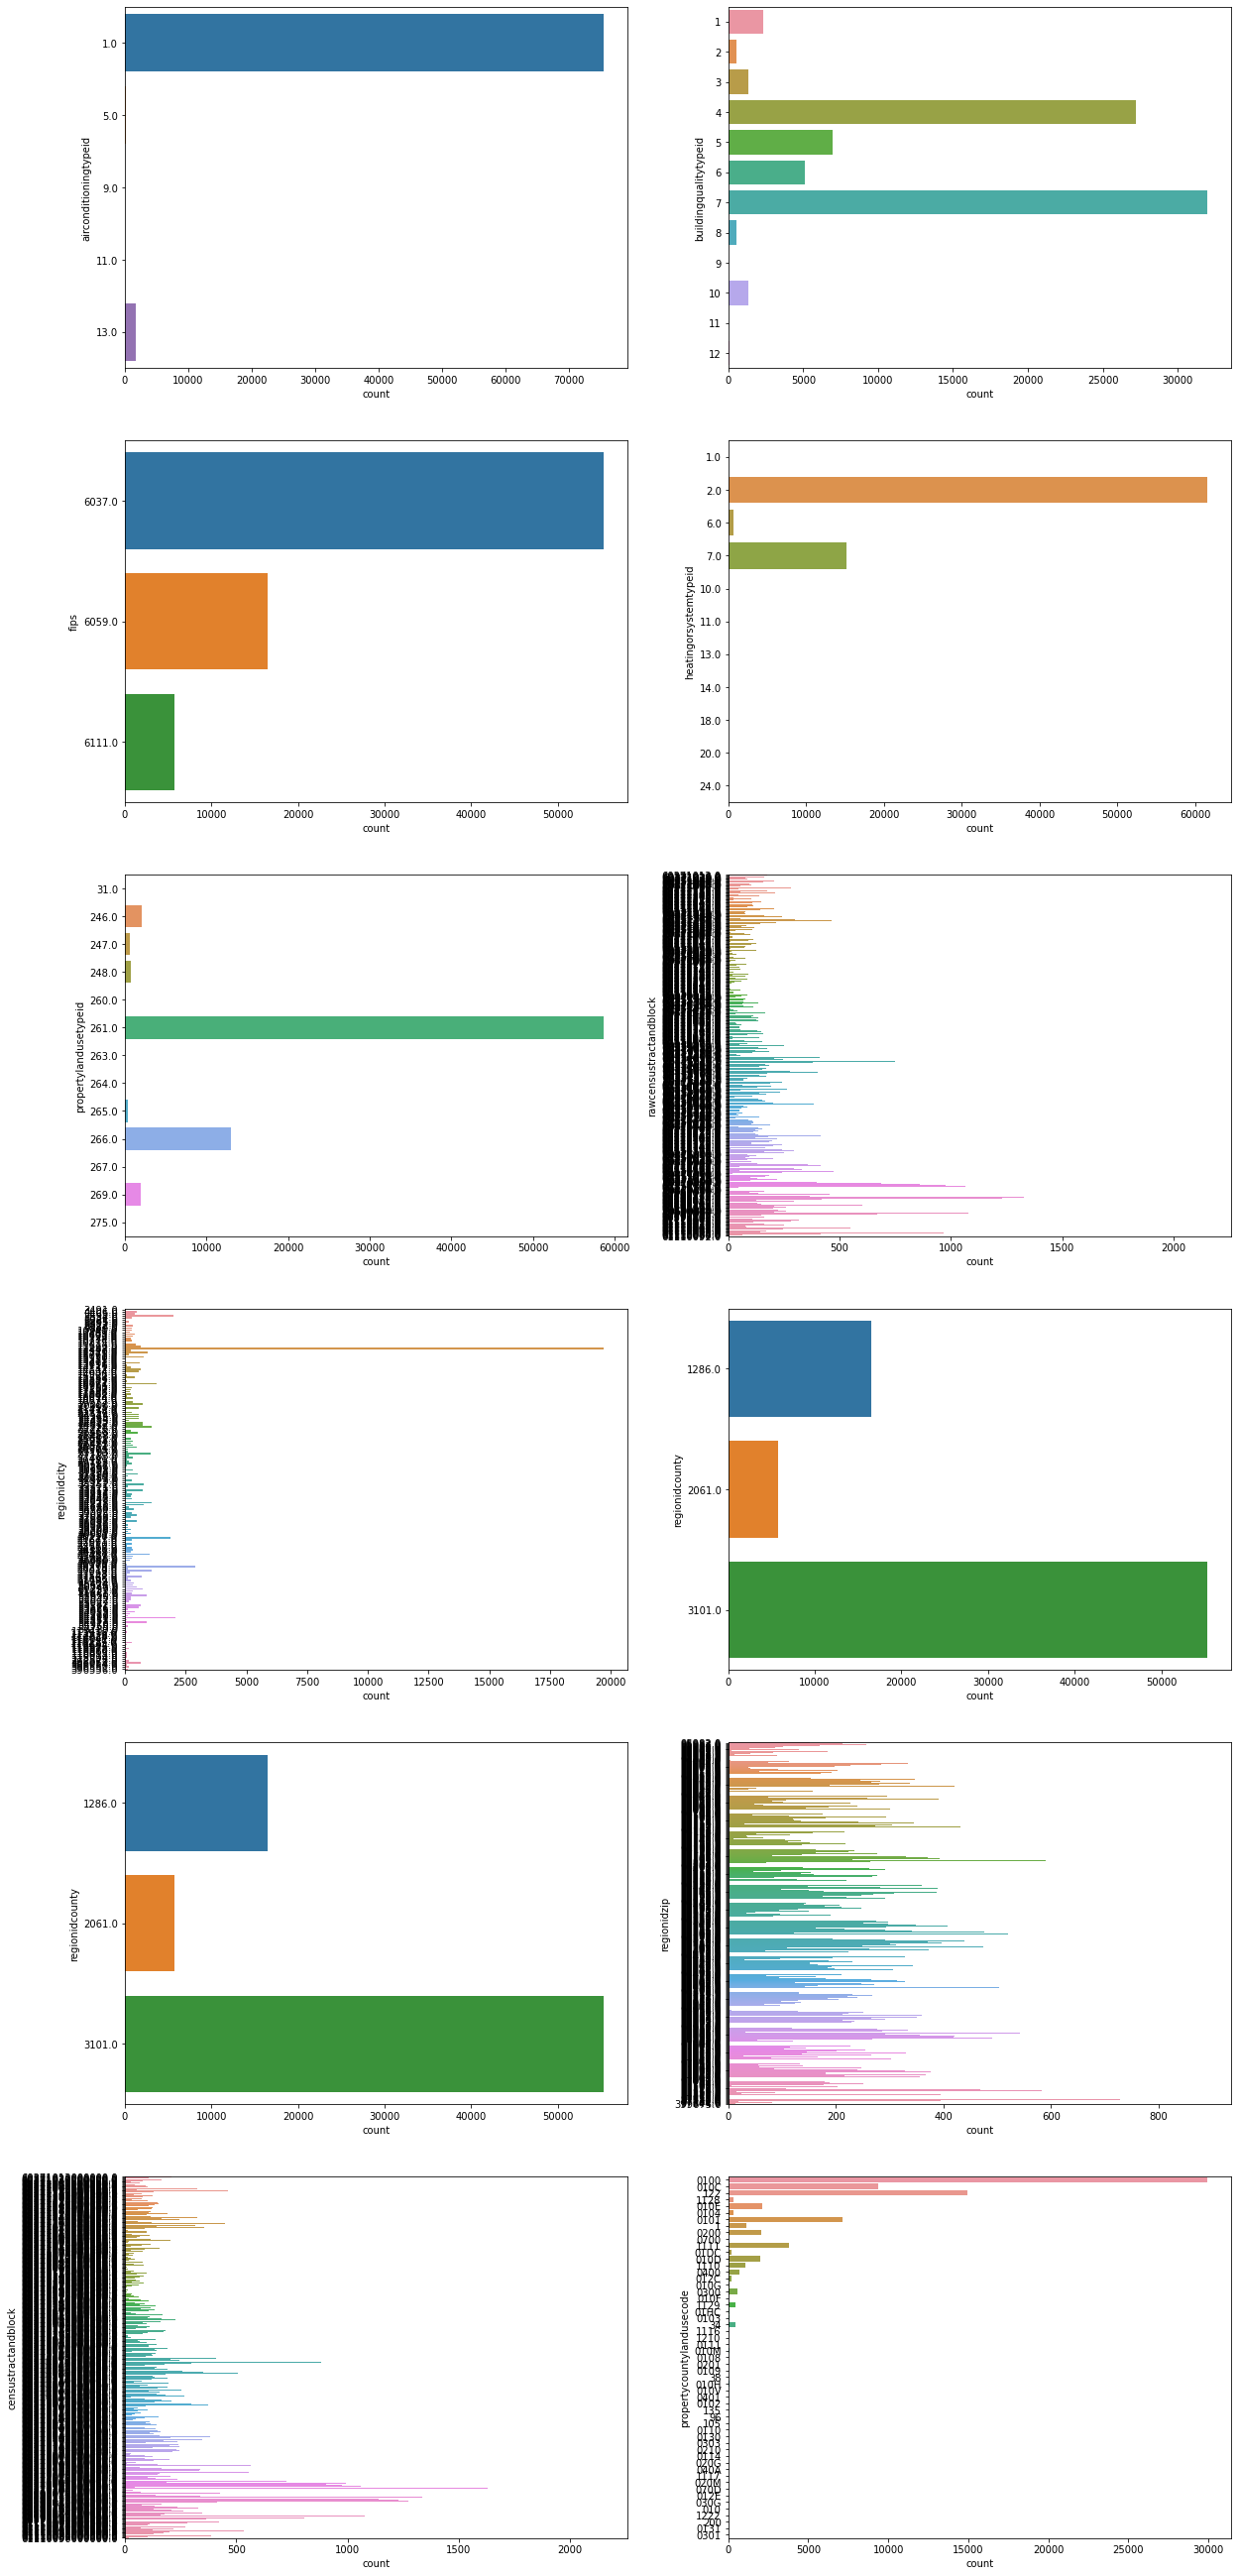

In [56]:
plt.figure(figsize=(20,8*26))
for i,each in enumerate(cat_vars):
    plt.subplot(26,2,i+1)
    sns.countplot(y=df[each])

Some features have a large skew. Let's do a mathematical analysis to figure out if any features are more than 90% skewed towards one value

In [57]:
#from the above plots, we can spot some features with a consider amount of skewing in the data.
#We will analyze how much skewed the data exactly is, and then take action based on that.
#As a benchmark, features with more than 90% of data belonging to one category can be set as skewed
#We will find which of our categorical columns can be cateogirzed as skewed
skewed_cols = []
for each in cat_vars:
    if max(df[each].value_counts(normalize=True)*100) > 90:
        print(df[each].value_counts(normalize=True)*100)
        print('\n')
        skewed_cols.append(each)        

1.0     97.402447
13.0     2.320120
5.0      0.249045
11.0     0.027098
9.0      0.001290
Name: airconditioningtypeid, dtype: float64




airconditioningtypeid is heavily skewed. We can drop this feature.

In [58]:
df.drop('airconditioningtypeid', axis = 1, inplace = True)
cat_vars.remove('airconditioningtypeid')

Zipcodes can be more helpful if we bin them using the first three digits. 

In [59]:
df.regionidzip.apply(lambda x : str(x)[:3]).value_counts()/len(df)

963    0.141078
961    0.137646
962    0.126058
960    0.117542
969    0.110922
970    0.110651
964    0.103709
973    0.052325
965    0.044944
971    0.028169
959    0.025666
972    0.001123
399    0.000168
Name: regionidzip, dtype: float64

In [60]:
df['regionidzip'] = df.regionidzip.apply(lambda x : str(x)[:3])

In [61]:
# We don't need multiple geographic indicators
df.drop('regionidcity', axis = 1, inplace = True)
cat_vars.remove('regionidcity')
# Also dropping these admin columns 
df.drop(
    ['rawcensustractandblock', 'censustractandblock'],
    axis = 1,
    inplace = True
)
cat_vars.remove('rawcensustractandblock')
cat_vars.remove('censustractandblock')


In [62]:
df.columns

Index(['parcelid', 'logerror', 'transactiondate', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'propertylandusetypeid', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'unitcnt',
       'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount'],
      dtype='object')

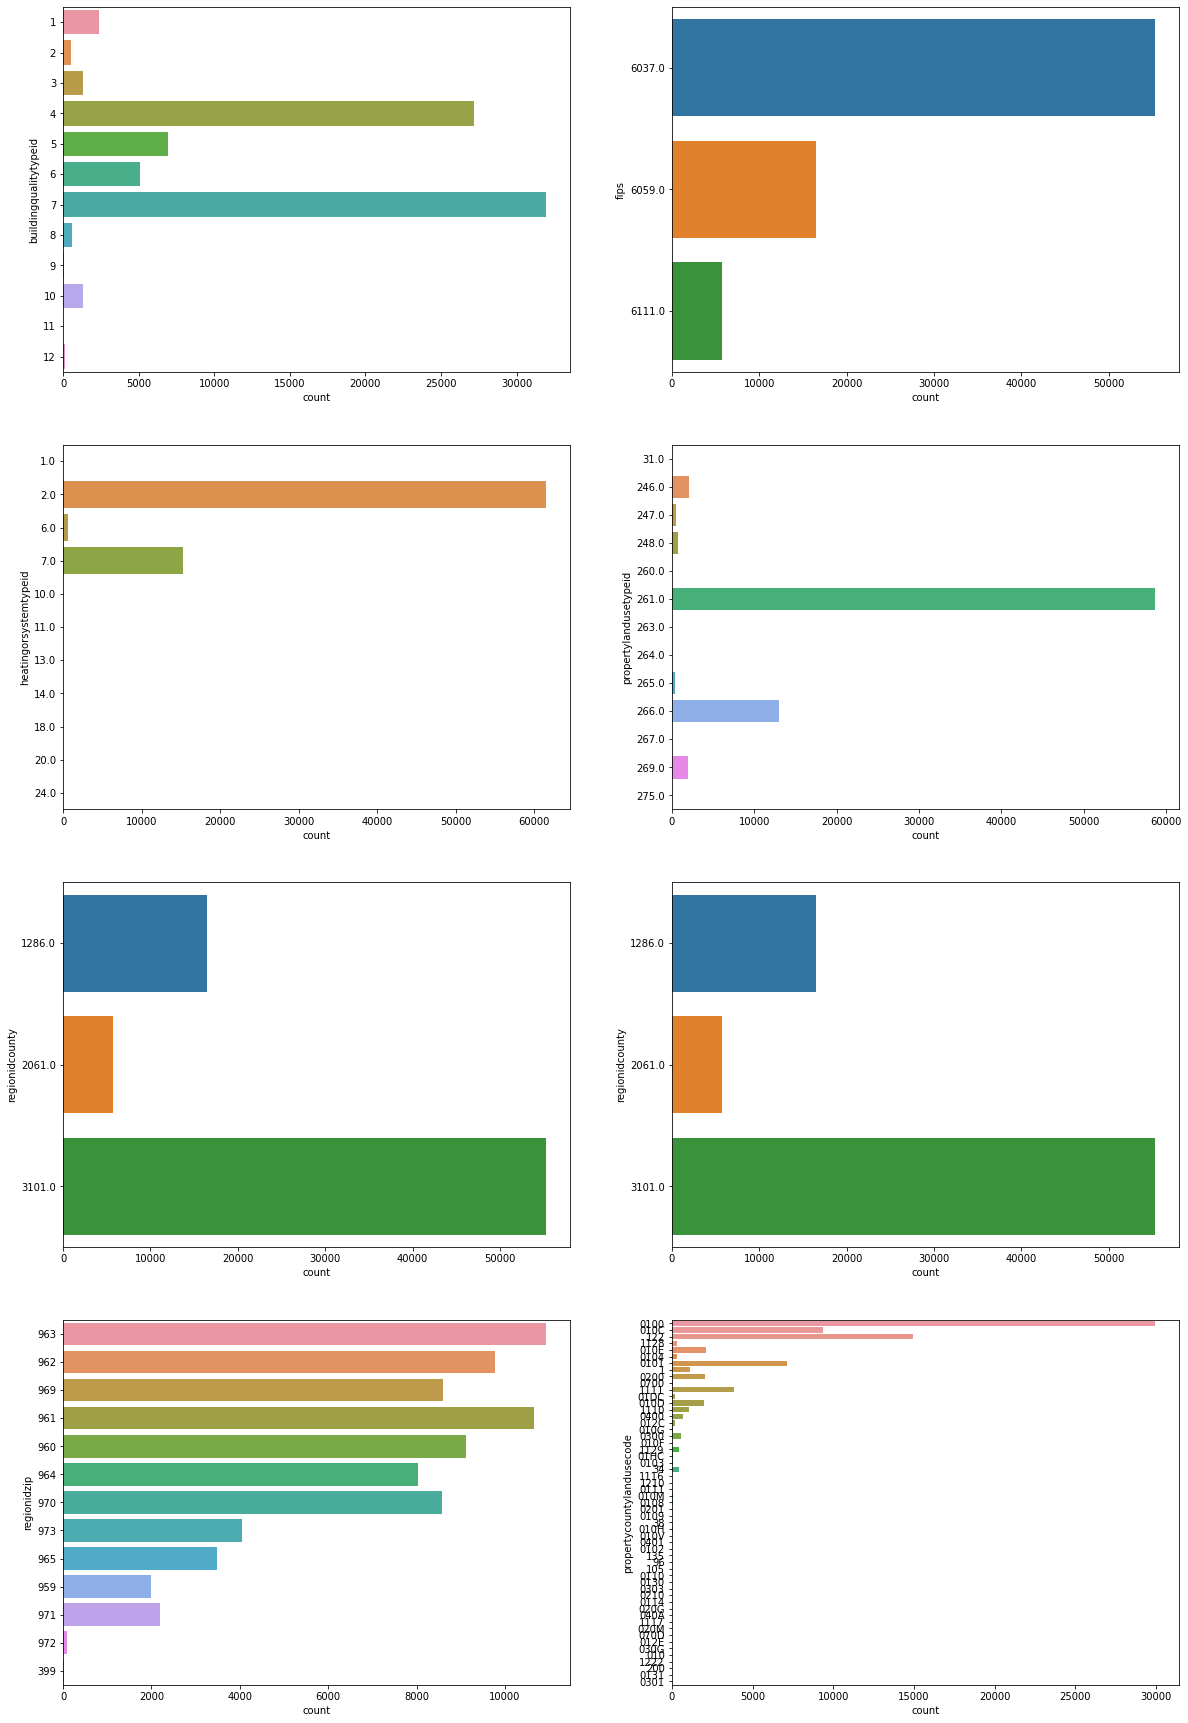

In [63]:
plt.figure(figsize=(20,8*26))
for i,each in enumerate(cat_vars):
    plt.subplot(26,2,i+1)
    sns.countplot(y=df[each])

Creating dummies for categorical nominal variables

In [64]:
df_dummies = pd.get_dummies(
    df.loc[:,cat_vars].apply(lambda x : x.astype('category')), 
    drop_first=True
)
df_dummies

,buildingqualitytypeid_2,buildingqualitytypeid_3,buildingqualitytypeid_4,buildingqualitytypeid_5,buildingqualitytypeid_6,buildingqualitytypeid_7,buildingqualitytypeid_8,buildingqualitytypeid_9,buildingqualitytypeid_10,buildingqualitytypeid_11,buildingqualitytypeid_12,fips_6059.0,fips_6111.0,heatingorsystemtypeid_2.0,heatingorsystemtypeid_6.0,heatingorsystemtypeid_7.0,heatingorsystemtypeid_10.0,heatingorsystemtypeid_11.0,heatingorsystemtypeid_13.0,heatingorsystemtypeid_14.0,heatingorsystemtypeid_18.0,heatingorsystemtypeid_20.0,heatingorsystemtypeid_24.0,propertylandusetypeid_246.0,propertylandusetypeid_247.0,propertylandusetypeid_248.0,propertylandusetypeid_260.0,propertylandusetypeid_261.0,propertylandusetypeid_263.0,propertylandusetypeid_264.0,propertylandusetypeid_265.0,propertylandusetypeid_266.0,propertylandusetypeid_267.0,propertylandusetypeid_269.0,propertylandusetypeid_275.0,regionidcounty_2061.0,regionidcounty_3101.0,regionidcounty_2061.0,regionidcounty_3101.0,regionidzip_959,...,propertycountylandusecode_010V,propertycountylandusecode_0110,propertycountylandusecode_0111,propertycountylandusecode_0114,propertycountylandusecode_012C,propertycountylandusecode_012E,propertycountylandusecode_0130,propertycountylandusecode_0131,propertycountylandusecode_01DC,propertycountylandusecode_01HC,propertycountylandusecode_0200,propertycountylandusecode_0201,propertycountylandusecode_020G,propertycountylandusecode_020M,propertycountylandusecode_0210,propertycountylandusecode_0300,propertycountylandusecode_0301,propertycountylandusecode_0303,propertycountylandusecode_030G,propertycountylandusecode_0400,propertycountylandusecode_0401,propertycountylandusecode_040A,propertycountylandusecode_0700,propertycountylandusecode_070D,propertycountylandusecode_1,propertycountylandusecode_105,propertycountylandusecode_1110,propertycountylandusecode_1111,propertycountylandusecode_1116,propertycountylandusecode_1117,propertycountylandusecode_1128,propertycountylandusecode_1129,propertycountylandusecode_1210,propertycountylandusecode_122,propertycountylandusecode_1222,propertycountylandusecode_135,propertycountylandusecode_200,propertycountylandusecode_34,propertycountylandusecode_38,propertycountylandusecode_96
0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77491,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
77492,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
77493,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
77494,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,

In [65]:
# Merging dummy varaibles into original data frame
df = pd.concat([df,df_dummies],axis = 1)
# Dropping original variables
df.drop(cat_vars,axis=1,inplace=True)

In [66]:
df.shape

(77496, 129)

Let us visualize some numerical variables

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


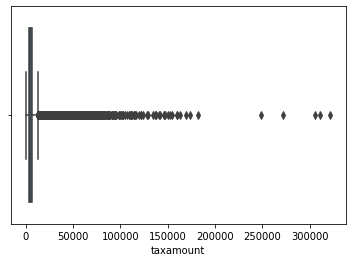

In [67]:
sns.boxplot(df.taxamount)

In [68]:
df.taxamount.describe(
    percentiles = [.25, .5, .75, .8, .9, .95, .98, .99, .999]
)

count     77496.000000
mean       6049.916992
std        7092.662598
min          49.080002
25%        2861.619934
50%        4559.489990
75%        6920.227417
80%        7789.779785
90%       10938.509766
95%       15476.060303
98%       23575.699219
99%       31953.695410
99.9%     80997.916914
max      321936.093750
Name: taxamount, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


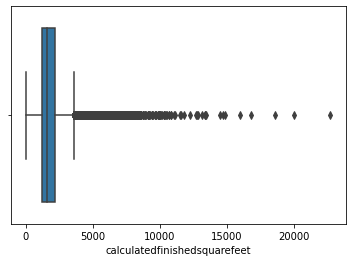

In [69]:
sns.boxplot(df.calculatedfinishedsquarefeet)

In [70]:
df.calculatedfinishedsquarefeet.describe(
    percentiles = [.25, .5, .75, .8, .9, .95, .98, .99, .999]
)

count    77496.000000
mean      1808.460571
std        940.590942
min          2.000000
25%       1209.000000
50%       1571.000000
75%       2150.000000
80%       2337.000000
90%       2924.000000
95%       3543.000000
98%       4379.000000
99%       5173.100000
99.9%     8366.020000
max      22741.000000
Name: calculatedfinishedsquarefeet, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


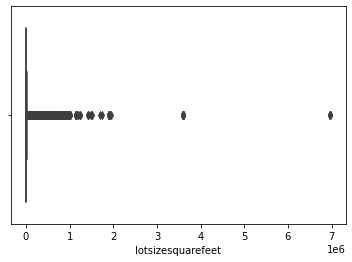

In [71]:
sns.boxplot(df.lotsizesquarefeet)

In [72]:
df.lotsizesquarefeet.apply(lambda x: x/100000).describe(
    percentiles = [.25, .5, .75, .8, .9, .95, .98, .99, .999]
)

count    77496.000000
mean         0.282315
std          1.172900
min          0.001670
25%          0.057020
50%          0.072000
75%          0.116000
80%          0.153720
90%          0.444310
95%          1.213020
98%          2.596401
99%          4.365882
99.9%        9.860800
max         69.710100
Name: lotsizesquarefeet, dtype: float64

## 4. Train-Test Split

In [73]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    df.drop('logerror', axis = 1),
    df['logerror'],
    test_size=.51
)

In [74]:
x_train.shape

(37973, 128)

In [75]:
y_train.shape

(37973,)

In [76]:
x_test.shape

(39523, 128)

In [77]:
y_test.shape

(39523,)

## 5. Building the Model

Scaling features

In [78]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.drop(['transactiondate'], axis = 1)
)

In [79]:
x_test_scaled = scaler.transform(
    x_test.drop(['transactiondate'], axis = 1)
)

We need to change the date column to ordinal so that it can be processed by regressors

In [80]:
x_train_2 = x_train.copy()
x_train_2['transactiondate'] = x_train_2['transactiondate'].apply(lambda x: x.toordinal())
x_test_2 = x_test.copy()
x_test_2['transactiondate'] = x_test_2['transactiondate'].apply(lambda x: x.toordinal())

# Ridge Regression using KFold + GridSearchCV

In [81]:
import warnings
warnings.filterwarnings("ignore", message="Ill-conditioned matrix")
#List of parameters (alpha values) to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, GridSearchCV
ridge = Ridge()
%time
# cross validation
folds = KFold(n_splits = 5, shuffle = True, random_state = 1)
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose=1)            
model_cv.fit(x_train_2, y_train) 

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs
Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [82]:
model_cv.best_params_

{'alpha': 1000}

In [83]:
abs(model_cv.best_score_)

0.06993709245226856

Since the best param found by GridSearch was the highest one, let us retry with a higher range (10^3 to 10^10)

In [84]:
import warnings
warnings.filterwarnings("ignore", message="Ill-conditioned matrix")
#List of parameters (alpha values) to tune
params = {'alpha': [10**i for i in range(3,10)]}

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, GridSearchCV
ridge = Ridge()
%time
# cross validation
folds = KFold(n_splits = 5, shuffle = True, random_state = 1)
model_cv2 = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose=1)            
model_cv2.fit(x_train_2, y_train) 
abs(model_cv2.best_score_)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 7.63 µs
Fitting 5 folds for each of 7 candidates, totalling 35 fits


0.06990869054007437

In [85]:
model_cv2.best_params_

{'alpha': 10000}

In [86]:
# Using the best parameter found by grid search
from sklearn.metrics import mean_absolute_error as mae
ridge2 = Ridge(alpha = 10000)
ridge2.fit(x_train_2, y_train)
mae(
    y_test,
    ridge2.predict(x_test_2)
)

0.06886721416093601

We have obtained an MAE of 0.0688 using Ridge regression on the test set

# Random Forest Regressor

In [87]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators = 150, random_state = 42,
    max_depth=10,
    min_samples_leaf=2
)
rf.fit(x_train_2, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=150,
                      random_state=42)

MAE

In [88]:
print('Train MAE: ', end = '')
print(mae(y_train, rf.predict(x_train_2)))
print('Test MAE: ', end = '')
print(mae(y_test, rf.predict(x_test_2)))

Train MAE: 0.06826542702740168
Test MAE: 0.06971459867553527


We might be able to improve the model performance on test data by making sure it is not overfitting. We can do so by further bumping up the number of estimators and the minimum samples per leaf.

In [89]:
rf2 = RandomForestRegressor(
    n_estimators = 300, random_state = 42,
    max_depth=10,
    min_samples_leaf=3,
)
rf2.fit(x_train_2, y_train)
print('Train MAE: ', end = '')
print(mae(y_train, rf2.predict(x_train_2)))
print('Test MAE: ', end = '')
print(mae(y_test, rf2.predict(x_test_2)))

Train MAE: 0.0683701658268071
Test MAE: 0.06958823451043156


A decent performance gain! We now have a test set MAE of 0.0695

Let us take a look at the feature importance for the Ridge regressor we previously built

In [102]:
coef_df = pd.DataFrame(
    {
     'feature':list(x_train_2.columns),
     'coef':list(ridge2.coef_)
    }
)
coef_df['mod_coef'] = coef_df.coef.apply(lambda x: abs(x))
coef_df.sort_values(by = 'mod_coef', ascending = False).head(20)

,feature,coef,mod_coef
75,propertycountylandusecode_0101,-0.002459,0.002459
74,propertycountylandusecode_0100,0.002400,0.002400
67,regionidzip_964,0.001624,0.001624
3,bedroomcnt,-0.001332,0.001332
62,regionidzip_959,-0.001317,0.001317
54,propertylandusetypeid_266.0,0.001251,0.001251
26,buildingqualitytypeid_5,0.001170,0.001170
73,regionidzip_973,-0.001152,0.001152
8,garagecarcnt,0.001077,0.001077
28,buildingqualitytypeid_7,0.001031,0.001031


We can observe the top contributing features in the output above.

# Pickle Export

The Ridge regressor seems to show the best stable performance when ran with alpha as 10000. Exporting this model

In [90]:
import pickle
pickle.dump(ridge2, open('ridge.model', 'wb'))